In [1]:
import generaluse as gu
import resultsmanaging as rm

import pandas as pd
import cv2
import skimage as ski

import imgproc as ip
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
folder_name = 'batch03'

dictionary = gu.getImgNamesAndPaths(f"rawdata/{folder_name}")

list_filenames = list(dictionary.keys())
list_filepaths = [*dictionary.values()]

list_data = []
for name, path in zip(list_filenames,list_filepaths):
    data = dict()
    data["Filename"] = name
    data["Filepath"] = path
    list_data.append(data)

dataframe = pd.DataFrame(data=list_data)
dataframe

Filename                            Filepath
0  Experiment-863.jpg  rawdata/batch03/Experiment-863.jpg
1  Experiment-866.jpg  rawdata/batch03/Experiment-866.jpg
2  Experiment-867.jpg  rawdata/batch03/Experiment-867.jpg
3  Experiment-868.jpg  rawdata/batch03/Experiment-868.jpg
4  Experiment-869.jpg  rawdata/batch03/Experiment-869.jpg
5  Experiment-870.jpg  rawdata/batch03/Experiment-870.jpg
6  Experiment-871.jpg  rawdata/batch03/Experiment-871.jpg

In [3]:
list_imgs = gu.getImagesFromPathfile(list_filepaths,cv2.COLOR_BGR2GRAY)

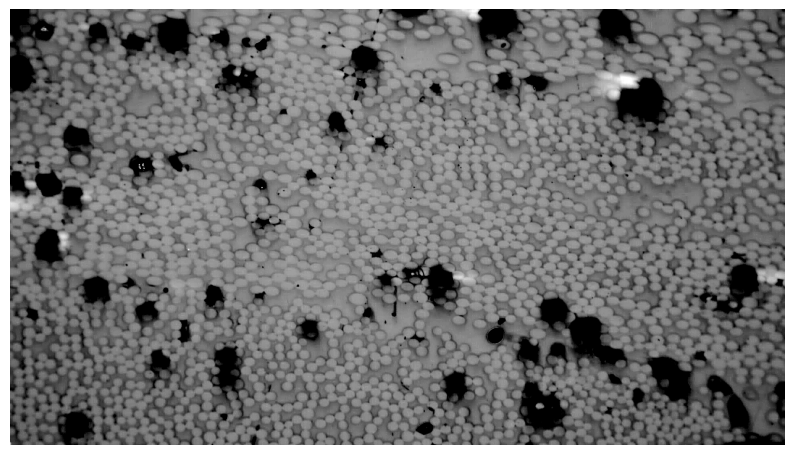

(-0.5, 1919.5, 1079.5, -0.5)

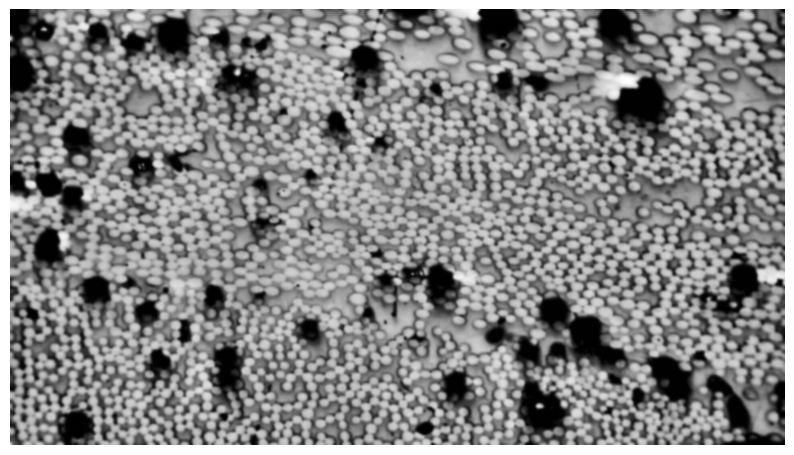

In [14]:
img_selected = list_imgs[0]

fig = plt.figure(figsize=(10, 10))
plt.imshow(img_selected, cmap='gray')
plt.axis('off')
plt.show()

test_1 = cv2.GaussianBlur(img_selected, (7, 7), 0)
clahe = cv2.createCLAHE(clipLimit=2,tileGridSize=(10, 10))
test_2 = cv2.GaussianBlur(clahe.apply(test_1), (11, 11), 0)

fig = plt.figure(figsize=(10, 10))
plt.imshow(test_2, cmap='gray')
plt.axis('off')

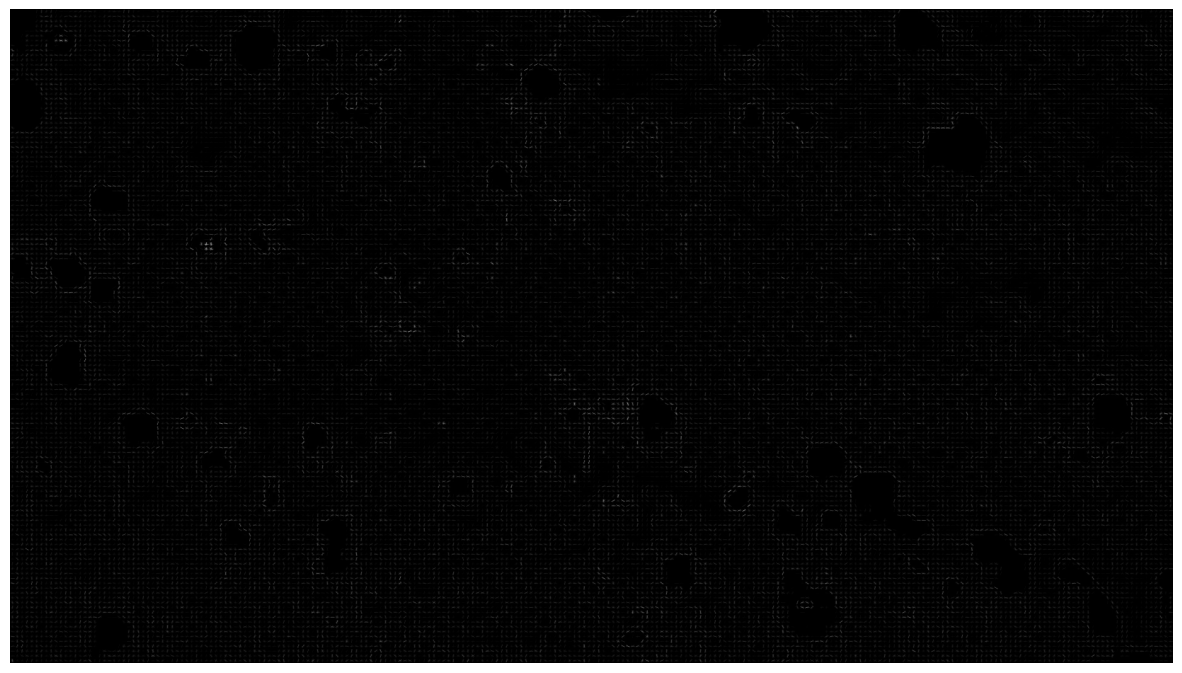

In [7]:
from skimage.feature import hog
from skimage.transform import resize

def extract_hog_features(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    """
    Extrae características HOG de una imagen
    
    Parámetros:
    - image: imagen en escala de grises
    - pixels_per_cell: tamaño de cada celda para calcular el histograma
    - cells_per_block: número de celdas en cada bloque para normalización
    - orientations: número de bins en el histograma de gradientes
    
    Retorna:
    - features: vector de características HOG
    - hog_image: imagen visualización HOG (opcional)
    """
    # Asegurar tamaño consistente de imagen
    resized_img = resize(image, (128, 128))
    
    # Extraer características HOG
    features, hog_image = hog(
        image, 
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        visualize=True,
        block_norm='L2-Hys'
    )
    
    return features, hog_image

feaures, hog_image = extract_hog_features(img_selected)

fig = plt.figure(figsize=(15, 15))
plt.imshow(hog_image, cmap='gray')
plt.axis('off')
plt.show()

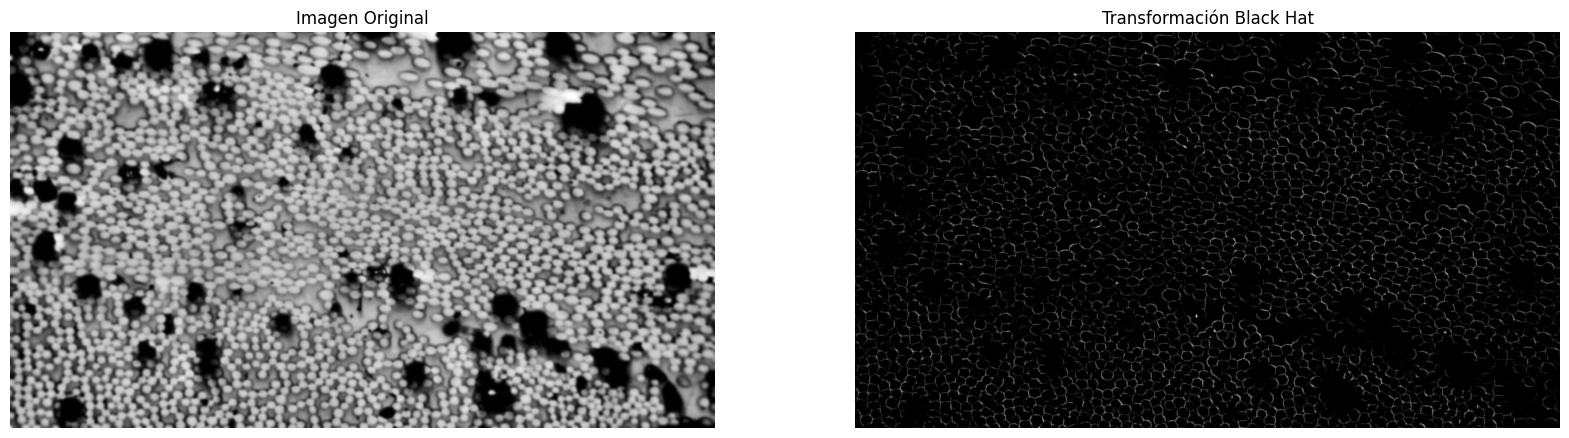

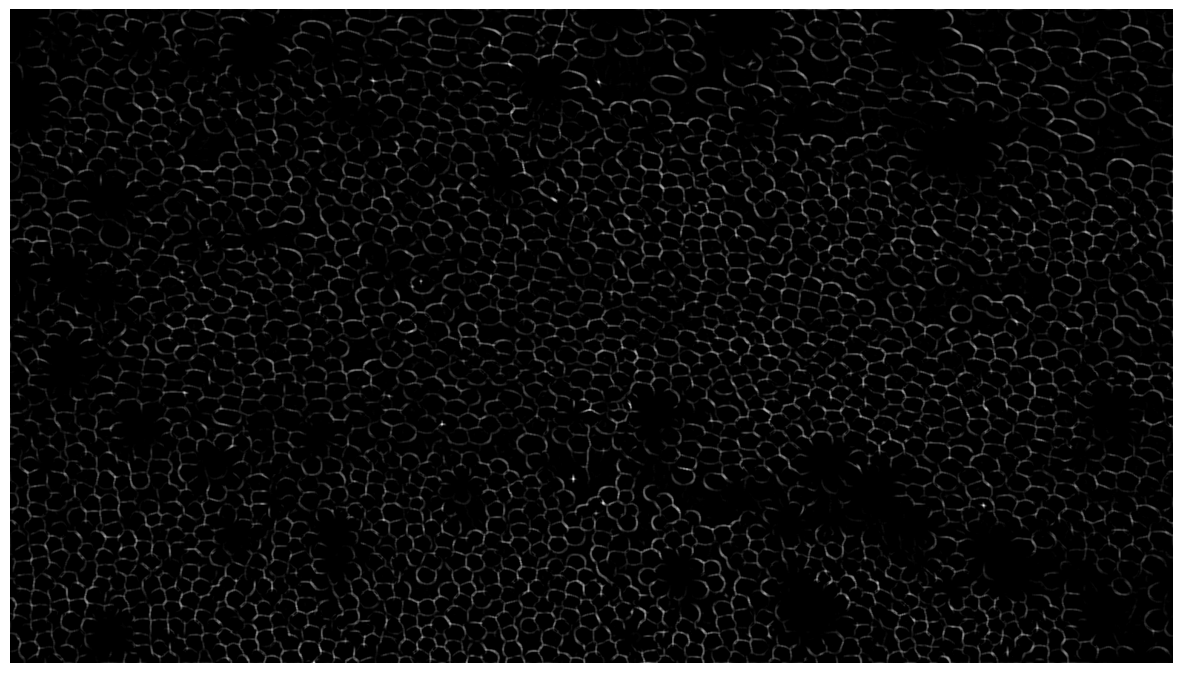

In [17]:
def analyze_black_hat(image, kernel_size=(5,5)):
    """
    Aplica la transformación Black Hat a una imagen
    
    Parámetros:
    - image: imagen en escala de grises
    - kernel_size: tamaño del kernel para la operación morfológica
    
    Retorna:
    - black_hat: imagen resultante de la transformación
    """
    # Crear kernel para operación morfológica
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    
    # Aplicar transformación Black Hat
    black_hat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)
    
    return black_hat

# Aplicar Black Hat a la imagen seleccionada
black_hat_img = analyze_black_hat(test_2, kernel_size=(5, 5))

# Visualizar resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

ax1.imshow(test_2, cmap='gray')
ax1.set_title('Imagen Original')
ax1.axis('off')

ax2.imshow(black_hat_img, cmap='gray')
ax2.set_title('Transformación Black Hat')
ax2.axis('off')

fig = plt.figure(figsize=(15, 15))
plt.imshow(black_hat_img, cmap='gray')
plt.axis('off')
plt.show()

plt.show()

In [21]:
list_ts = ski.filters.threshold_multiotsu(black_hat_img, classes=5)
print(list_ts)

[ 2  5  9 15]


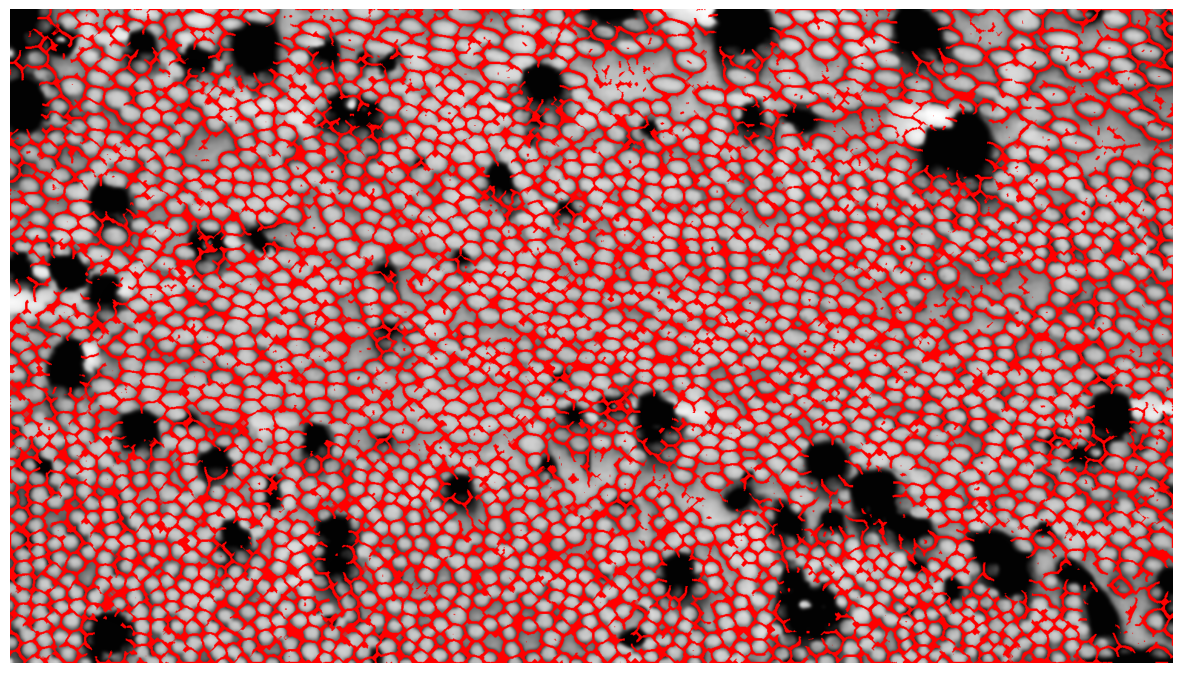

In [177]:
black_hat_mask = black_hat_img

kernel = np.array([[0, 1, 0],
                   [1, 0, 1],
                   [0, 1, 0]], dtype=np.uint8)

black_hat_mask = cv2.morphologyEx(black_hat_mask, cv2.MORPH_CLOSE, kernel,iterations=4)


test_2_rgb = cv2.cvtColor(test_2, cv2.COLOR_GRAY2RGB)
test_2_rgb[black_hat_mask > 0] = [255, 0, 0]  # Color rojo para la máscara

fig = plt.figure(figsize=(15, 15))
plt.imshow(test_2_rgb)
plt.axis('off')
plt.show()

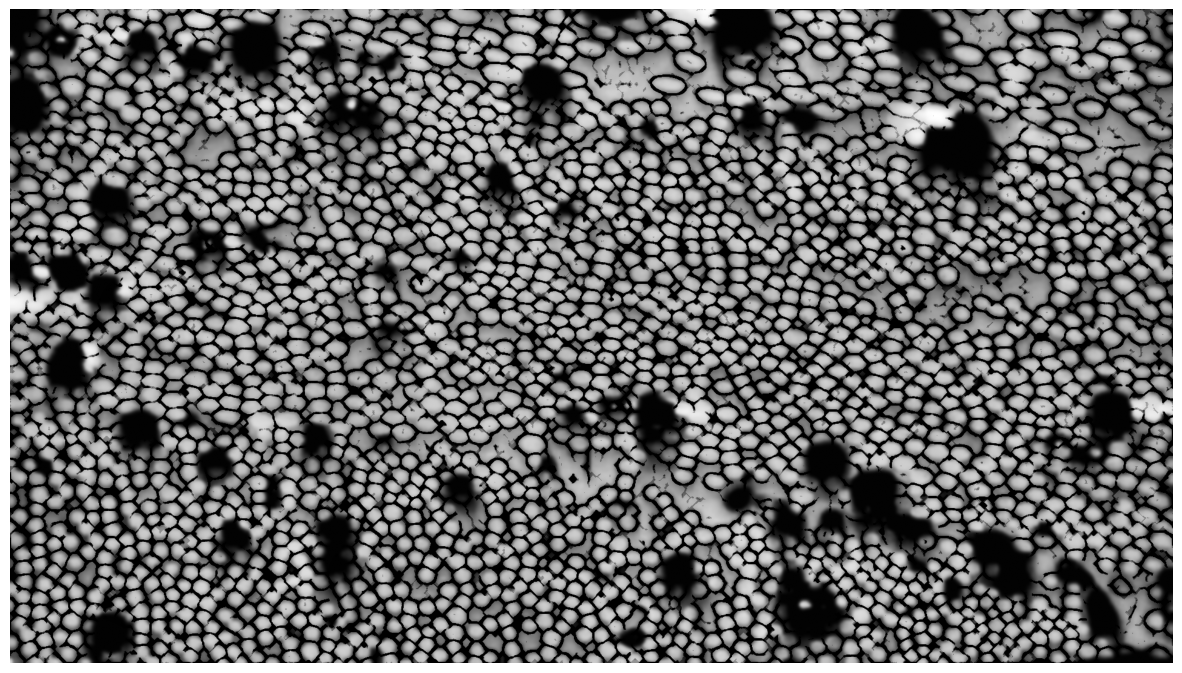

In [178]:
test_3 = np.int16(test_2) - 60*np.int16(black_hat_mask)
test_3[test_3 < 0] = 0
test_3 = np.uint8(test_3)

fig = plt.figure(figsize=(15, 15))
plt.imshow(test_3, cmap='gray')
plt.axis('off')
plt.show()

In [179]:
list_ts_test3 = ski.filters.threshold_multiotsu(test_3, classes=5)
print(list_ts_test3)

[ 33  89 135 173]


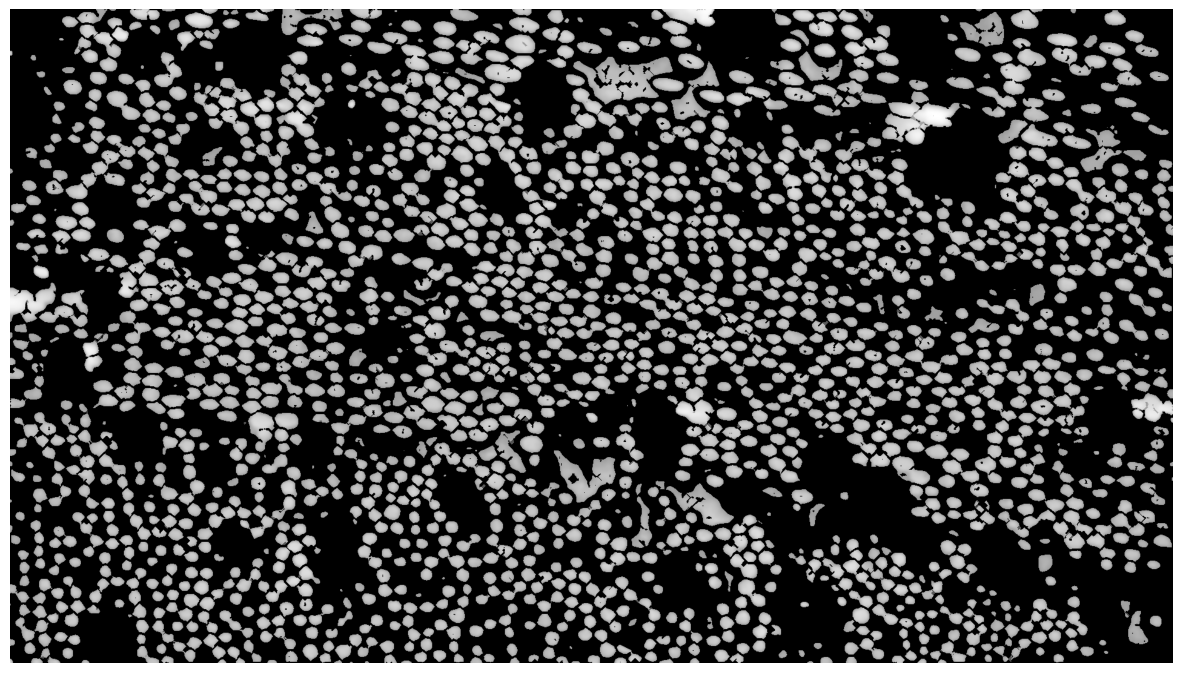

In [180]:
thresh_1 = np.zeros(np.shape(test_3),dtype=np.uint8)

thresh_1[test_3 > np.mean(list_ts_test3[2:])] = 255 

test_4 = test_3.copy()
test_4[~(thresh_1 == 255)] = 0


fig = plt.figure(figsize=(15,15))
plt.imshow(test_4,cmap='gray',vmin=0,vmax=255)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Number of contours: 1871


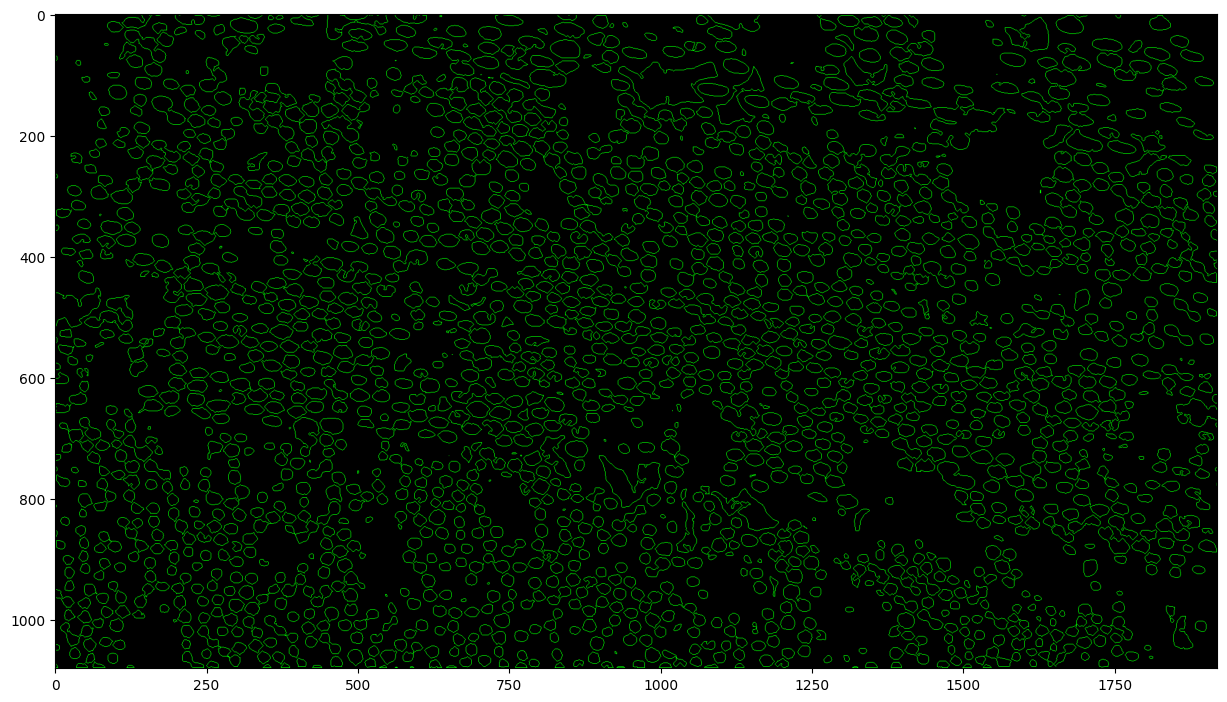

34.26777124532336
21.029195640133928


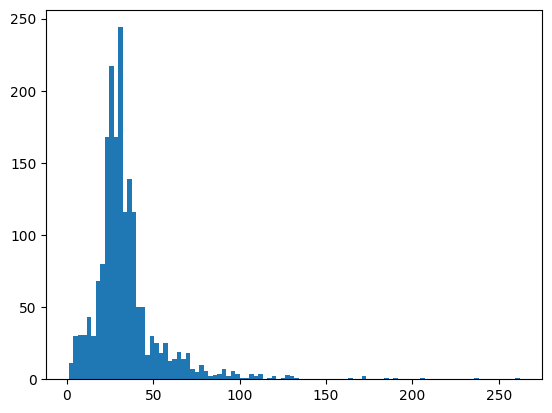

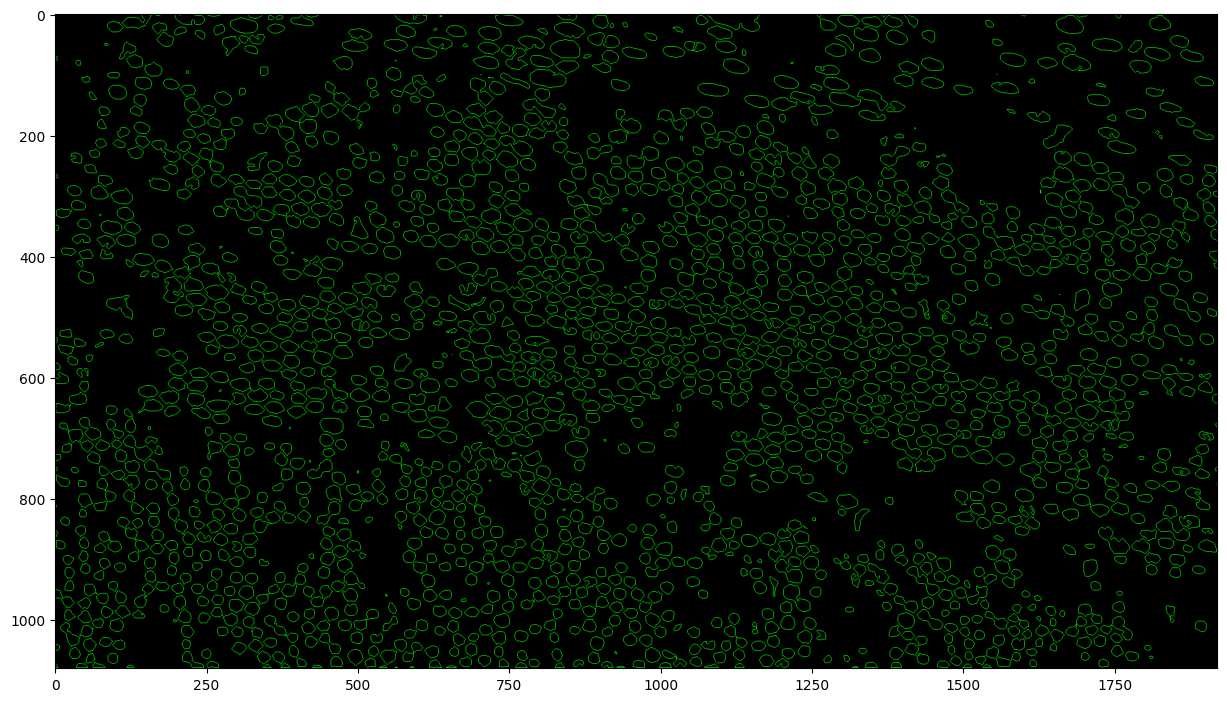

In [181]:
test_5 = test_4.copy()
test_5[test_5 > 0] = 255

contours_fibers, hierarchy_fibers = cv2.findContours(image=test_5, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

print(f"Number of contours: {len(contours_fibers)}")

dim = np.shape(test_5)

img_contornos_2 = cv2.drawContours(np.zeros((dim[0],dim[1],3)), contours_fibers, -1, (0,255,0), 1)
img_contornos_3 = np.uint8(img_contornos_2)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_contornos_2,vmin=0,vmax=255)
plt.show()

contours_fibers_lenght = [len(c) for c in contours_fibers]

cfl_mean = np.mean(contours_fibers_lenght)
cfl_std = np.std(contours_fibers_lenght)

print(cfl_mean)
print(cfl_std)

plt.hist(contours_fibers_lenght, bins=100)
plt.show()

contours_fibers_filtered = [c for c in contours_fibers if len(c) < cfl_mean + 2*cfl_std]

img_contornos_3 = cv2.drawContours(np.zeros((dim[0],dim[1],3)), contours_fibers_filtered, -1, (0,255,0), 1)
img_contornos_3 = np.uint8(img_contornos_3)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_contornos_3,vmin=0,vmax=255)
plt.show()

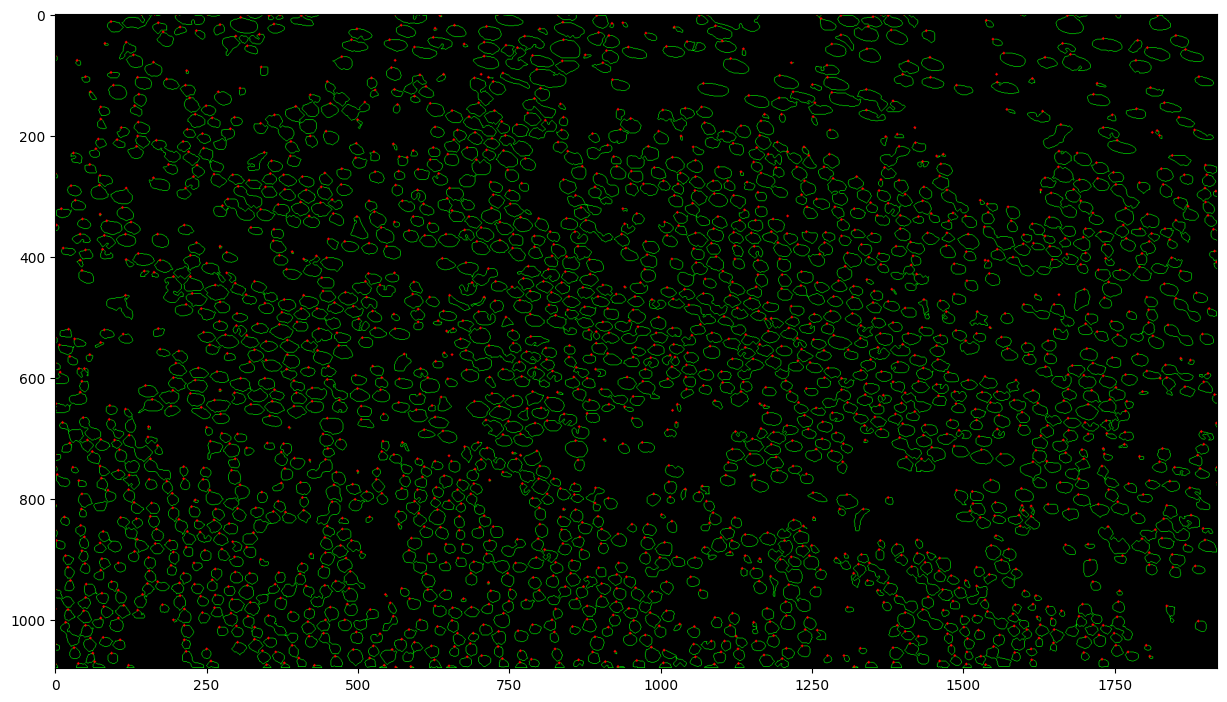

In [182]:
first_element_of_contours_2 = np.array([np.uint32(contours_fibers_filtered[i][0][0]) for i in range(len(contours_fibers_filtered))])
img_points_2 = img_contornos_3.copy()

for p in first_element_of_contours_2:
    cv2.circle(img_points_2, (p[0],p[1]), 2, (255,0,0), -1)


fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_points_2,vmin=0,vmax=255)
plt.show()

[(1078, 562), (1077, 1319)]


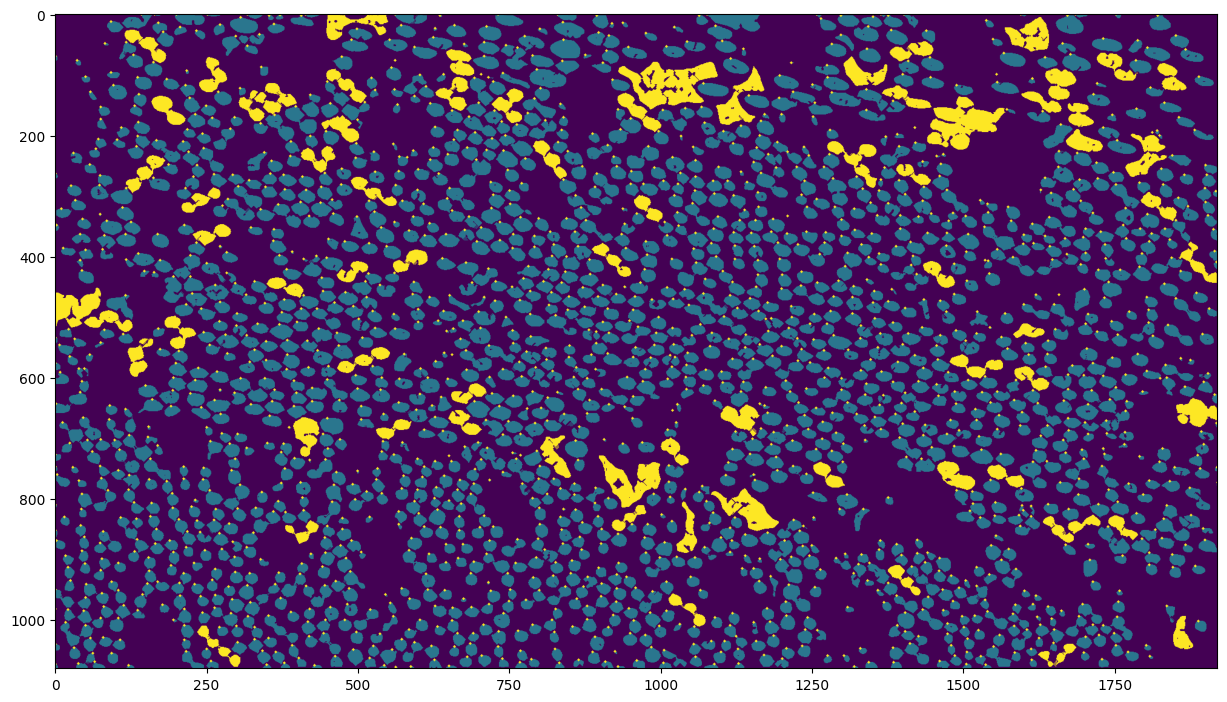

In [183]:
list_coordinates_2 = [(np.uint16(p[1]),np.uint16(p[0])) for p in first_element_of_contours_2]
print(list_coordinates_2[0:2])

test_9 = test_4.copy()
test_9[test_9 != 0] = 255

list_masks_2 = []

for coordinate in list_coordinates_2:
    mask = ski.segmentation.flood(test_9, coordinate, tolerance=1)
    list_masks_2.append(mask)
    test_9[mask] = 100

for p in first_element_of_contours_2:
    cv2.circle(test_9, (p[0],p[1]), 2, (255,0,0), -1)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(test_9,vmin=0,vmax=255)
plt.show()

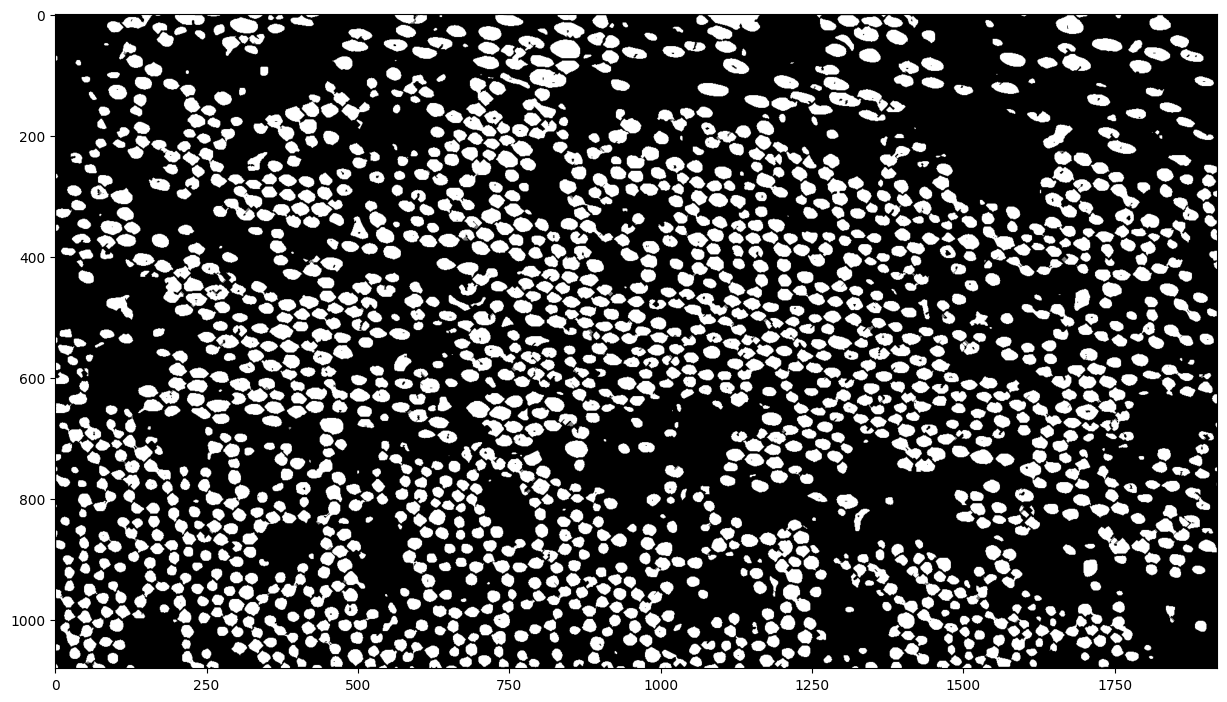

In [184]:
mask_fibers = np.zeros(np.shape(test_4),dtype=np.uint8)
for mask in list_masks_2:
    mask_fibers[mask] = 255

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mask_fibers,cmap='gray',vmin=0,vmax=255)
plt.show()